# How to handle  Inventory multi-source reconciliation :
I understand the three-way matching process: aligning purchase orders, goods received, and invoices.

We’ll simulate 3 datasets in Jupyter (Pandas DataFrames):   purchase_orders.csv,    goods_received.csv,   invoices.csv

We'll simulate a mismatch or two so we can clean + catch them.        This notebook simulates a 3-way match between:
- Purchase Orders (PO)
- Goods Received Notes (GRN)
- Invoices

It includes data cleaning, merging, comparison, and mismatch detection.


In [1]:
import pandas as pd

# Sample Purchase Orders
df_po = pd.DataFrame({
    'po_number': ['PO-001', 'PO-002', 'PO-003'],
    'item': ['nike shoes', 'Adidas T-shirt', 'puma socks'],
    'quantity': [10, 20, 15],
    'price': [100.00, 20.00, 5.00]
})

# Sample Goods Received
df_grn = pd.DataFrame({
    'po_number': [' PO-001 ', 'PO-002', 'PO-003'],
    'item': ['Nike Shoes', 'adidas tshirt', 'Puma Socks'],
    'quantity_received': [10, 19, 15]
})

# Sample Invoices
df_invoice = pd.DataFrame({
    'po_number': ['po-001', 'PO-002', 'PO-003'],
    'item': ['Nike Shoes', 'Adidas T-shirt', 'Puma Socks'],
    'quantity_billed': [10, 20, 15],
    'price': [100.00, 20.00, 5.00]
})

In [4]:
df_invoice.head()

,po_number,item,quantity_billed,price,item_clean
0,po-001,Nike Shoes,10,100.0,nike shoes
1,po-002,Adidas T-shirt,20,20.0,adidas tshirt
2,po-003,Puma Socks,15,5.0,puma socks


In [6]:
df_grn.head()

,po_number,item,quantity_received,item_clean
0,po-001,Nike Shoes,10,nike shoes
1,po-002,adidas tshirt,19,adidas tshirt
2,po-003,Puma Socks,15,puma socks


In [7]:
df_po.head()

,po_number,item,quantity,price,item_clean
0,po-001,nike shoes,10,100.0,nike shoes
1,po-002,Adidas T-shirt,20,20.0,adidas tshirt
2,po-003,puma socks,15,5.0,puma socks


In [8]:
# Clean and normalize item/PO names
def clean_text(val):
    return val.strip().lower().replace('-', '').replace('  ', ' ')

for df in [df_po, df_grn, df_invoice]:
    df['po_number'] = df['po_number'].str.strip().str.lower()
    df['item_clean'] = df['item'].apply(clean_text)

In [9]:
# Merge datasets
df_merged = df_po.merge(df_grn, on='po_number', suffixes=('', '_grn')) \
                 .merge(df_invoice, on='po_number', suffixes=('', '_inv'))

In [10]:
df_merged.head()

,po_number,item,quantity,price,item_clean,item_grn,quantity_received,item_clean_grn,item_inv,quantity_billed,price_inv,item_clean_inv
0,po-001,nike shoes,10,100.0,nike shoes,Nike Shoes,10,nike shoes,Nike Shoes,10,100.0,nike shoes
1,po-002,Adidas T-shirt,20,20.0,adidas tshirt,adidas tshirt,19,adidas tshirt,Adidas T-shirt,20,20.0,adidas tshirt
2,po-003,puma socks,15,5.0,puma socks,Puma Socks,15,puma socks,Puma Socks,15,5.0,puma socks


In [11]:
# Compare quantities and prices
df_merged['qty_match'] = (
    (df_merged['quantity'] == df_merged['quantity_received']) &
    (df_merged['quantity'] == df_merged['quantity_billed'])
)
df_merged['price_match'] = df_merged['price'] == df_merged['price_inv']
df_merged['item_match'] = (
    (df_merged['item_clean'] == df_merged['item_clean_grn']) &
    (df_merged['item_clean'] == df_merged['item_clean_inv'])
)

In [13]:
df_merged['qty_match'].value_counts()

qty_match
True     2
False    1
Name: count, dtype: int64

In [15]:
df_merged['price_match'].value_counts()

price_match
True    3
Name: count, dtype: int64

In [16]:
# Find mismatches  : This code filters the df_merged DataFrame to select only the rows where at least one of the conditions
# (qty_match, price_match, or item_match) is False. This is useful for identifying and isolating the mismatched records.
mismatches = df_merged[
    ~(df_merged['qty_match'] & df_merged['price_match'] & df_merged['item_match'])
]
mismatches

,po_number,item,quantity,price,item_clean,item_grn,quantity_received,item_clean_grn,item_inv,quantity_billed,price_inv,item_clean_inv,qty_match,price_match,item_match
1,po-002,Adidas T-shirt,20,20.0,adidas tshirt,adidas tshirt,19,adidas tshirt,Adidas T-shirt,20,20.0,adidas tshirt,False,True,True


## Dashboard with plotly that shows the mismatches
Each plot is a bar chart (px.bar) where:

The x-axis is the respective match column (e.g., qty_match, price_match, item_match).

The bars are colored based on whether the match is True (match) or False (mismatch), using specific colors for visual clarity.



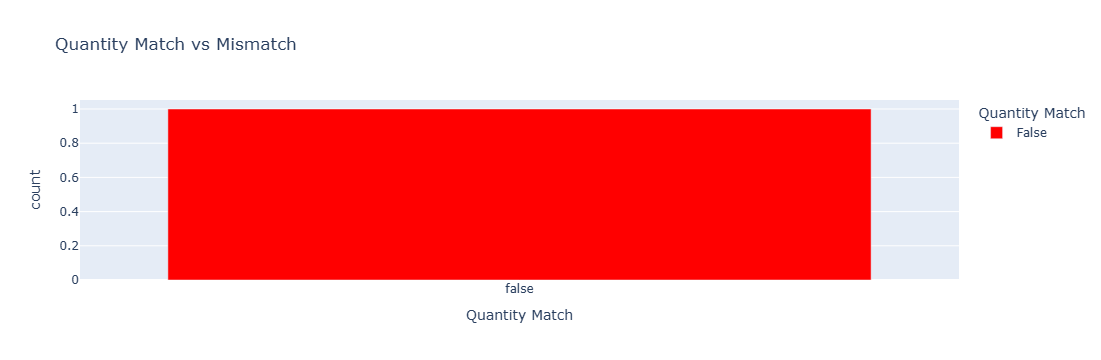

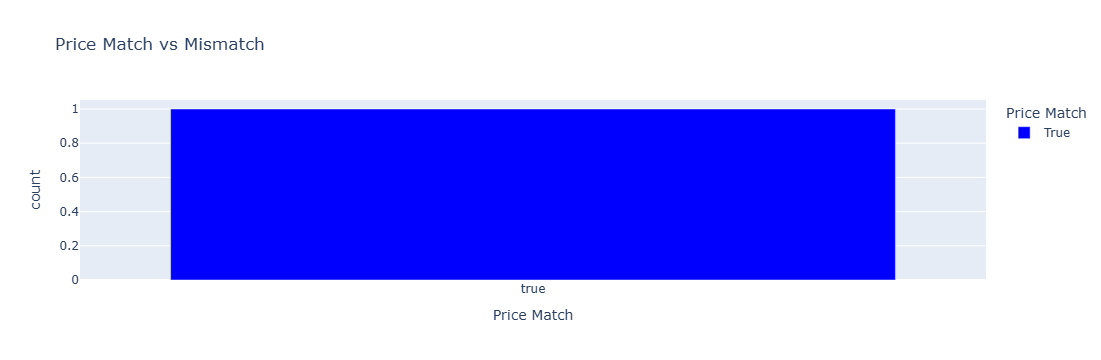

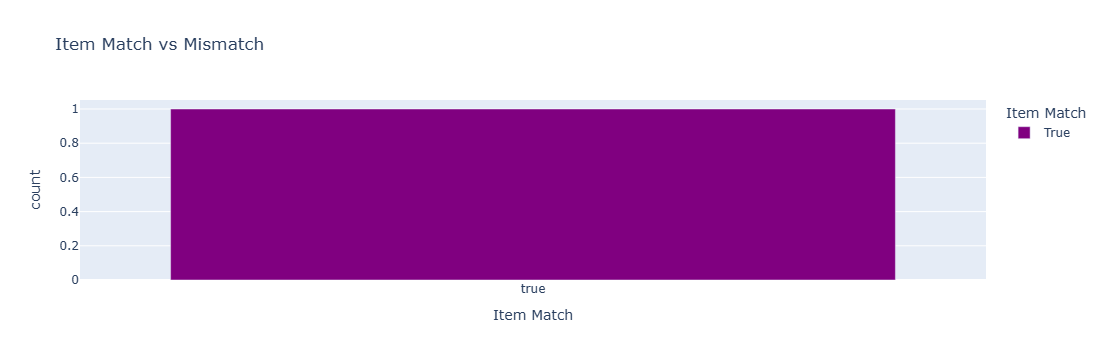

In [21]:
import plotly.express as px

# Plot a bar chart for mismatched quantities
fig_qty = px.bar(
    mismatches,
    x='qty_match',  # Column indicating quantity match (True/False)
    title="Quantity Match vs Mismatch",
    labels={'qty_match': 'Quantity Match'},
    color='qty_match',  # Color by True/False match
    color_discrete_map={True: 'green', False: 'red'},  # Green for match, Red for mismatch
    category_orders={'qty_match': [True, False]}  # Order bars: Match first, then Mismatch
)

# Plot a bar chart for mismatched prices
fig_price = px.bar(
    mismatches,
    x='price_match',  # Column indicating price match (True/False)
    title="Price Match vs Mismatch",
    labels={'price_match': 'Price Match'},
    color='price_match',  # Color by True/False match
    color_discrete_map={True: 'blue', False: 'orange'},  # Blue for match, Orange for mismatch
    category_orders={'price_match': [True, False]}  # Order bars: Match first, then Mismatch
)

# Plot a bar chart for mismatched items
fig_item = px.bar(
    mismatches,
    x='item_match',  # Column indicating item match (True/False)
    title="Item Match vs Mismatch",
    labels={'item_match': 'Item Match'},
    color='item_match',  # Color by True/False match
    color_discrete_map={True: 'purple', False: 'yellow'},  # Purple for match, Yellow for mismatch
    category_orders={'item_match': [True, False]}  # Order bars: Match first, then Mismatch
)

# Show all the plots
fig_qty.show()
fig_price.show()
fig_item.show()


    

In [ ]:
import plotly.express as px

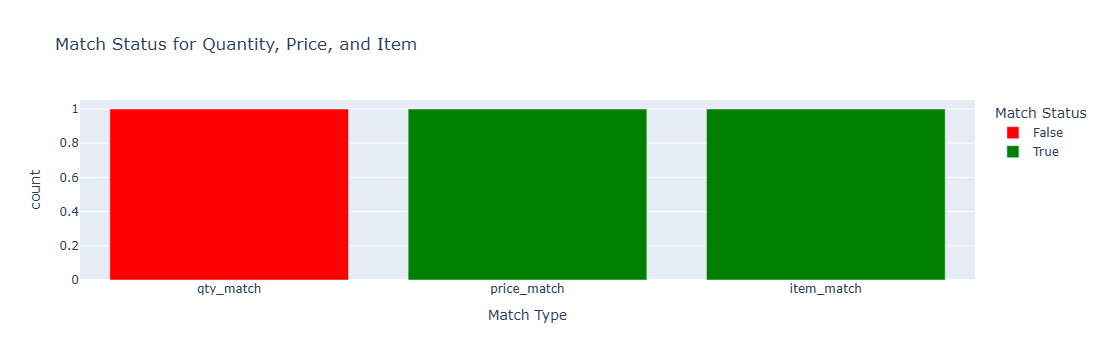

In [20]:
# Reshaping the data so that we can plot all three match types in one chart - i used mismatches.melt() to reshape the mismatches DataFrame
#into a long format, where:
    # The Match Type column contains values like qty_match, price_match, and item_match.
    # The Match Status column contains the Boolean values (True/False) from each match column.


mismatches_long = mismatches.melt(
    id_vars=[],  # No ID column, just reshape all columns
    value_vars=['qty_match', 'price_match', 'item_match'],  # The match columns
    var_name='Match Type',  # New column for the match type (Qty, Price, Item)
    value_name='Match Status'  # New column for the match status (True/False)
)

# Now, creating the combined bar chart
fig_combined = px.bar(
    mismatches_long,
    x='Match Type',  # x-axis will be the match type (Qty, Price, Item)
    color='Match Status',  # Color bars by the match status (True/False)
    title="Match Status for Quantity, Price, and Item",
    labels={'Match Type': 'Match Type', 'Match Status': 'Match Status'},
    color_discrete_map={True: 'green', False: 'red'},  # Green for match, Red for mismatch
    category_orders={'Match Type': ['qty_match', 'price_match', 'item_match']}  # Order of match types
)

# Show the combined plot
fig_combined.show()


## From MySQL exporting the final SQL table to a pandas DataFrame

In [23]:
pip install mysql-connector-python

   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
   --- ------------------------------------ 1.6/16.1 MB 10.5 MB/s eta 0:00:02
   ---------- ----------------------------- 4.2/16.1 MB 12.0 MB/s eta 0:00:01
   ------------------ --------------------- 7.6/16.1 MB 13.4 MB/s eta 0:00:01
   ---------------------------- ----------- 11.3/16.1 MB 14.7 MB/s eta 0:00:01
   ------------------------------------ --- 14.7/16.1 MB 15.4 MB/s eta 0:00:01
   ---------------------------------------- 16.1/16.1 MB 14.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import mysql.connector

try:
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="  ",  # try the one you remember
        database="inventory_management"
    )

    if conn.is_connected():
        print("✅ Connection successful!")

except mysql.connector.Error as err:
    print(f"❌ Error: {err}")


✅ Connection successful!


In [4]:
import pandas as pd

In [5]:
# Load data from the final table (update the table name!)
query = "SELECT * FROM final_inventory_comparison;"  # Replace with your actual table name
df = pd.read_sql(query, conn)


C:\Users\Mirela Giantaru\AppData\Local\Temp\ipykernel_24440\2257289938.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [6]:
conn.close()

In [8]:
df.head() ## values differ due to a difft database, with other value was created in MySQL

,order_id,item_id,po_quantity,gr_quantity,vi_quantity,po_price,vi_price,quantity_match,price_match,item_match
0,1,101,50,50,50,10.0,10.0,Match,Match,Match
1,2,102,30,30,30,15.0,15.0,Match,Match,Match
2,3,103,20,20,20,25.0,25.0,Match,Match,Match
